# UAS Graf Sains Data - Node Classification dengan GNN
## Universitas Negeri Surabaya - Program Studi S1 Sains Data

**Tujuan**: Implementasi Graph Neural Network (GNN) untuk node classification pada dataset Cora menggunakan Torch-Geometric

### Rumus yang Diimplementasikan

**1. Pra-proses (Message Passing Layer)**:
$$h_u^{(k)} = \sum_{u \in N(v)} W_{msg} h_u^{(k-1)} + W_{self} h_v^{(k-1)}$$

di mana:
- $k$ = urutan lapisan GNN
- $N(v)$ = tetangga node $v$
- $W_{msg}$ = bobot pesan untuk node tetangga
- $W_{self}$ = bobot untuk node asal (self-loop)
- Aggregation menggunakan operasi `add`

**2. Intra-layer GNN (Processing Layer)**:
$$h_v^{(k)} = ACT(DROPOUT(BatchNorm(W \cdot h_v^{(k-1)} + b) + h_v^{(k-1)}))$$

di mana:
- $ACT$ = aktivasi ReLU
- $DROPOUT$ = Dropout regularization
- $BatchNorm$ = 1D Batch Normalization
- Residual connection ditambahkan antara input dan output

In [335]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing, BatchNorm
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import random

In [336]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [337]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

In [338]:
node_of_interest = random.randint(0, data.num_nodes - 1)
print("Node of Interest:", node_of_interest)

# extract 2-hop subgraph
subset_nodes, sub_edge_index, _, _ = k_hop_subgraph(
    node_of_interest, 
    num_hops=2, 
    edge_index=data.edge_index, 
    relabel_nodes=True
)

sub_x = data.x[subset_nodes]
sub_y = data.y[subset_nodes]

print("Subgraph Nodes:", sub_x.size(0))

Node of Interest: 1001
Subgraph Nodes: 5


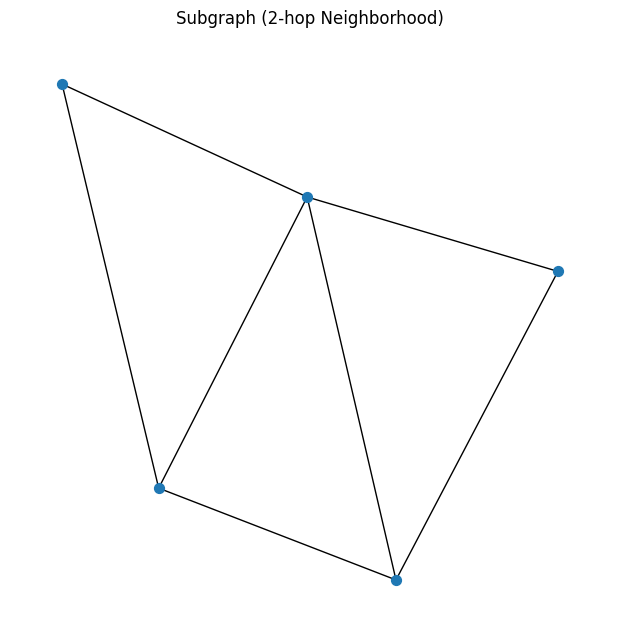

In [339]:
G = to_networkx(
    Data(x=sub_x, edge_index=sub_edge_index), 
    to_undirected=True
)

plt.figure(figsize=(6,6))
nx.draw(G, node_size=50)
plt.title("Subgraph (2-hop Neighborhood)")
plt.show()

In [340]:
#Jumlah Node
data.num_nodes

2708

In [341]:
#jumlah edge
data.num_edges

10556

In [342]:
#dimensi fitur
data.num_features

1433

In [343]:
#jumlah keasl
dataset.num_classes

7

In [344]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [345]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [346]:
class_counts = data.y.bincount()
for class_idx in range(len(class_counts)):
    print(f"Kelas {class_idx}: {class_counts[class_idx].item()} nodes")

Kelas 0: 351 nodes
Kelas 1: 217 nodes
Kelas 2: 418 nodes
Kelas 3: 818 nodes
Kelas 4: 426 nodes
Kelas 5: 298 nodes
Kelas 6: 180 nodes


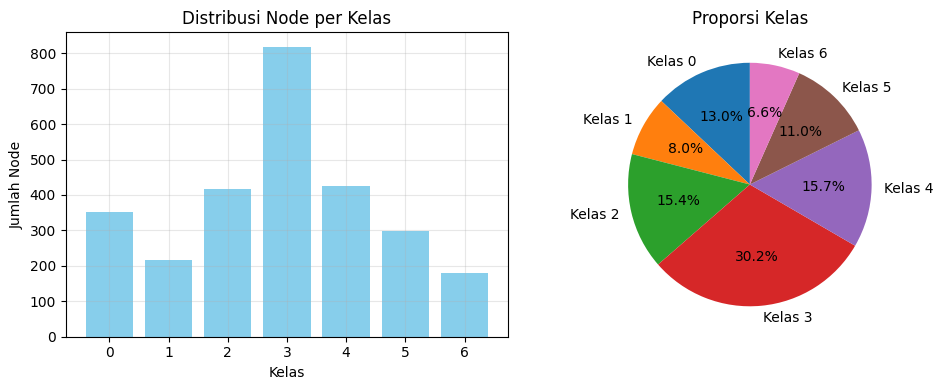

In [347]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(class_counts)), class_counts.numpy(), color='skyblue')
plt.title('Distribusi Node per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Node')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(class_counts.numpy(), labels=[f'Kelas {i}' for i in range(len(class_counts))], 
        autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Kelas')

plt.tight_layout()
plt.show()

In [348]:
#train nodes
data.train_mask.sum().item()

140

In [349]:
print(f"\nTrain ratio: {data.train_mask.sum().item()/data.num_nodes:.2%}")


Train ratio: 5.17%


In [350]:
#validation nodes
data.val_mask.sum().item()

500

In [351]:
print(f"Validation ratio: {data.val_mask.sum().item()/data.num_nodes:.2%}")

Validation ratio: 18.46%


In [352]:
#test nodes
data.test_mask.sum().item()

1000

In [353]:
print(f"Test ratio: {data.test_mask.sum().item()/data.num_nodes:.2%}")

Test ratio: 36.93%


In [354]:
data.edge_index.shape

torch.Size([2, 10556])

In [355]:
data.edge_index[:, :5]

tensor([[ 633, 1862, 2582,    2,  652],
        [   0,    0,    0,    1,    1]])

In [356]:
data.x[0, :10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# PRA-PROSES (Message Passing Layer)

$h_u^{(k)} = \sum W_{\text{msg}} \cdot h_u^{(k-1)} + W_{\text{self}} \cdot h_v^{(k-1)}$

 di mana,
 1. **k** adalah urutan lapisan GNN.
 2. **Wmsg** adalah bobot yang diakses bersama dengan neighborhood nodes.
 3. **Wself** adalah bobot milik node asal (v).

In [357]:
class CustomMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.W_msg = nn.Linear(in_channels, out_channels)  # For neighbors
        self.W_self = nn.Linear(in_channels, out_channels) # For self
        
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.W_msg(x_j)  # W_msg * h_u
    
    def update(self, aggr_out, x):
        return aggr_out + self.W_self(x)  # Σ + W_self * h_v

In [358]:
# TEST MESSAGE PASSING

test_mp = CustomMessagePassing(in_channels=16, out_channels=32)
test_mp

CustomMessagePassing()

In [359]:
test_mp.W_msg.weight.shape

torch.Size([32, 16])

In [360]:
test_mp.W_self.weight.shape

torch.Size([32, 16])

# Intra-layer GNN Block

$$
\mathbf{h}_v^{(k)} =
\text{ACT}\!\left(
    \text{Dropout}\!\left(
        \text{BatchNorm}\!\left(
            \mathbf{W}^{(k-1)}\,\mathbf{h}_v^{(k-1)} + \mathbf{b}^{(k-1)}
        \right)
    \right)
\right)
+ \mathbf{h}_v^{(k-1)}
$$


di mana:

1. **ACT** adalah fungsi aktivasi yang Anda pilih.
2. **BatchNorm** adalah `1D-Batch Normalization`.


## DEFINE SINGLE GNN LAYER 

In [361]:
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        
        #Add message passing layer!
        self.message_passing = CustomMessagePassing(in_channels, out_channels)
        
        # Linear transformation
        self.linear = nn.Linear(out_channels, out_channels)  # Changed from in_channels!
        
        # Required components
        self.batch_norm = BatchNorm(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
        #use residual
        if in_channels != out_channels:
            self.residual = nn.Linear(in_channels, out_channels)
        else:
            self.residual = nn.Identity()
    
    def forward(self, x, edge_index):
        x_input = x
        
        #USE MESSAGE PASSING!
        x_mp = self.message_passing(x, edge_index)  # This was missing!
        
        # Process
        x_linear = self.linear(x_mp)  # Changed from x_mp to x
        x_bn = self.batch_norm(x_linear)
        x_drop = self.dropout(x_bn)
        x_act = self.activation(x_drop)
        
        # Residual
        x_residual = self.residual(x_input)
        return x_act + x_residual  # This is correct now

## Test GNN Layer

In [362]:
test_layer = GNNLayer(in_channels=16, out_channels=32)
test_layer

GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (batch_norm): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Linear(in_features=16, out_features=32, bias=True)
)

In [363]:
test_layer.batch_norm

BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [364]:
test_layer.dropout.p

0.5

In [365]:
test_layer.activation

ReLU()

# Full Model with k>1 Layers

## Build Model

In [366]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        
        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # addmore layers with message passing
        self.layer1 = GNNLayer(hidden_channels, hidden_channels, dropout=0.5)
        self.layer2 = GNNLayer(hidden_channels, hidden_channels, dropout=0.5)
        self.layer3 = GNNLayer(hidden_channels, hidden_channels, dropout=0.3)
        self.layer4 = GNNLayer(hidden_channels, out_channels, dropout=0.3)  # Keep residual!
        
        # Classifier
        self.classifier = nn.Linear(out_channels, out_channels)
    
    def forward(self, x, edge_index):
        # Project features
        x = self.input_proj(x)
        
        # Multiple GNN layers
        x = self.layer1(x, edge_index)
        x = F.relu(x)
        x = self.layer2(x, edge_index)
        x = F.relu(x)
        x = self.layer3(x, edge_index)
        x = F.relu(x)
        x = self.layer4(x, edge_index) 
                
        # Classify
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

## Initialize Model

In [367]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [368]:
# model = GNNModel(
#     in_channels=data.num_features,
#     hidden_channels=512,
#     out_channels=dataset.num_classes
# ).to(device)

# print(f"Model created on {device}")

In [369]:
model = GNNModel(
    in_channels=data.num_features,
    hidden_channels=256,
    out_channels=dataset.num_classes
).to(device)

## CHECK MODEL PARAMETERS

In [370]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [371]:
print(f"Total parameters: {total_params:,}")

Total parameters: 966,291


In [372]:
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 966,291


In [373]:
print("\nParameter shapes:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name:30} {tuple(param.shape)}")


Parameter shapes:
  input_proj.0.weight            (256, 1433)
  input_proj.0.bias              (256,)
  layer1.message_passing.W_msg.weight (256, 256)
  layer1.message_passing.W_msg.bias (256,)
  layer1.message_passing.W_self.weight (256, 256)
  layer1.message_passing.W_self.bias (256,)
  layer1.linear.weight           (256, 256)
  layer1.linear.bias             (256,)
  layer1.batch_norm.module.weight (256,)
  layer1.batch_norm.module.bias  (256,)
  layer2.message_passing.W_msg.weight (256, 256)
  layer2.message_passing.W_msg.bias (256,)
  layer2.message_passing.W_self.weight (256, 256)
  layer2.message_passing.W_self.bias (256,)
  layer2.linear.weight           (256, 256)
  layer2.linear.bias             (256,)
  layer2.batch_norm.module.weight (256,)
  layer2.batch_norm.module.bias  (256,)
  layer3.message_passing.W_msg.weight (256, 256)
  layer3.message_passing.W_msg.bias (256,)
  layer3.message_passing.W_self.weight (256, 256)
  layer3.message_passing.W_self.bias (256,)
  layer3

## SET UP OPTIMIZER

In [374]:
# optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10
# )

In [375]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Use ReduceLROnPlateau to lower LR when validation stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

In [376]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # disabled: using ReduceLROnPlateau instead

In [ ]:
# More patience
patience = 50  # Was 20
epochs = 300   # Was 150

Patience: 100
Max Epochs: 1000


In [378]:
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Learning rate: 0.01


In [379]:
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")

Weight decay: 0.0005


In [380]:
# move data to device
data = data.to(device)
device
data.x.device
data.edge_index.device

device(type='cpu')

# Show Model Structure

In [381]:
model

GNNModel(
  (input_proj): Sequential(
    (0): Linear(in_features=1433, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (layer1): GNNLayer(
    (message_passing): CustomMessagePassing()
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (residual): Identity()
  )
  (layer2): GNNLayer(
    (message_passing): CustomMessagePassing()
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
    (residual): Identity()
  )
  (layer3): GNNLayer(
    (message_passing): CustomMessagePassing()
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (batch_norm): BatchNorm(256, eps=1e

In [382]:
for name, module in model.named_children():
    print(f"\n{name}: {module}")


input_proj: Sequential(
  (0): Linear(in_features=1433, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)

layer1: GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Identity()
)

layer2: GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): ReLU()
  (residual): Identity()
)

layer3: GNNLayer(
  (message_passing): CustomMessagePassing()
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dro

# Training

In [383]:
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Epochs: 150")
print(f"Early stopping patience: 20")
print(f"Device: {device}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.0005
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000001F620B8FBB0>
Learning rate: 0.01
Epochs: 150
Early stopping patience: 20
Device: cpu


## RAINING LOOP WITH VALIDATION LOSS

In [384]:
# def get_validation_loss(model, data):
#     model.eval()
#     with torch.no_grad():
#         out = model(data.x, data.edge_index)
#         loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
#     return loss.item()

# # Then track both losses:
# val_losses = []
# for epoch in range(epochs):
#     train_loss = train_one_epoch(...)
#     val_loss = get_validation_loss(model, data)
#     val_losses.append(val_loss)  # We're missing this!

## SEtup

In [385]:
train_losses = []
val_accuracies = []
test_accuracies = []

### DEFINE TRAINING STEP FUNCTION

In [386]:
def train_one_epoch(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
    optimizer.step()
    return loss.item()

In [387]:
def evaluate_full(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        
        # Losses
        train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]).item()
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
        
        # Accuracies
        train_acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).float().mean().item()
        val_acc = (out[data.val_mask].argmax(dim=1) == data.y[data.val_mask]).float().mean().item()
        test_acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).float().mean().item()
    
    return train_loss, val_loss, train_acc, val_acc, test_acc

### DEFINE EVALUATION FUNCTION

In [388]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        total = mask.sum().item()
        accuracy = correct / total
    return accuracy

## RUN EPOCH

In [ ]:
best_val_acc = 0
patience_counter = 0
patience = 50

# Increase epochs for better convergence
for epoch in range(300):
    # Train
    loss = train_one_epoch(model, data, optimizer)
    train_losses.append(loss)

    # Evaluate full metrics (loss + acc)
    train_loss, val_loss, train_acc, val_acc, test_acc = evaluate_full(model, data)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    # Step scheduler on validation accuracy (ReduceLROnPlateau expects the monitored metric)
    scheduler.step(val_acc)

    # Check best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f}, TestAcc={test_acc:.4f}')

    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'Best validation accuracy: {best_val_acc:.4f}')

Epoch   0: TrainLoss=87.0691, ValLoss=80.1071, ValAcc=0.1220, TestAcc=0.1300
Epoch  20: TrainLoss=0.0008, ValLoss=1.4761, ValAcc=0.6400, TestAcc=0.6670
Epoch  40: TrainLoss=0.0006, ValLoss=1.3487, ValAcc=0.6260, TestAcc=0.6580
Epoch  60: TrainLoss=0.0007, ValLoss=1.2959, ValAcc=0.6480, TestAcc=0.6670
Epoch  80: TrainLoss=0.0006, ValLoss=1.3308, ValAcc=0.6420, TestAcc=0.6600
Epoch 100: TrainLoss=0.0005, ValLoss=1.3355, ValAcc=0.6420, TestAcc=0.6580
Early stopping at epoch 113
Best validation accuracy: 0.6720


### Load best model

In [390]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

## PLOT

### Training loss

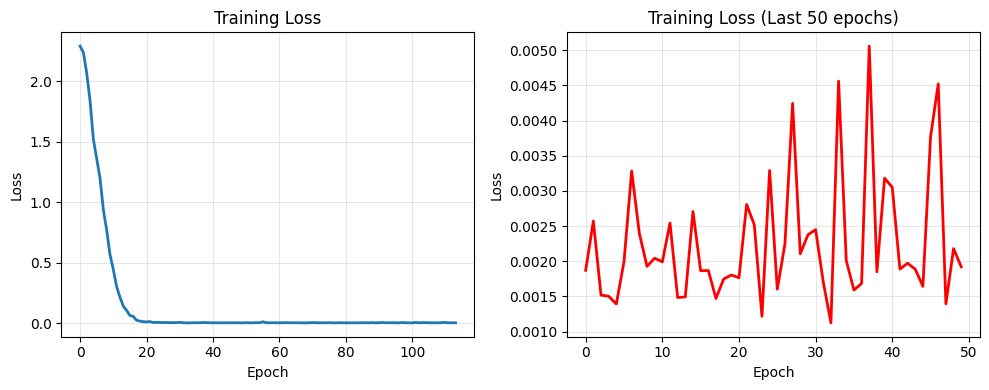

In [391]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Plot last 50 losses to see detail
plt.plot(train_losses[-50:], linewidth=2, color='red')
plt.title('Training Loss (Last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### ACCURACIES

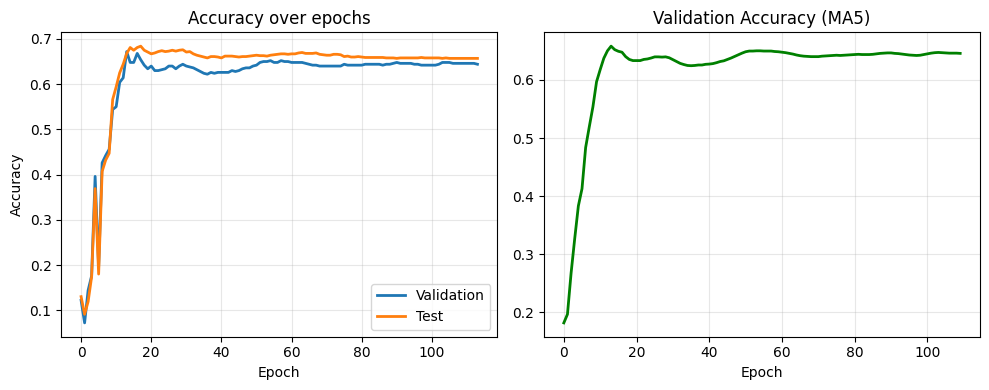

In [392]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation', linewidth=2)
plt.plot(test_accuracies, label='Test', linewidth=2)
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Moving average
window = 5
val_ma = np.convolve(val_accuracies, np.ones(window)/window, mode='valid')
plt.plot(val_ma, linewidth=2, color='green')
plt.title(f'Validation Accuracy (MA{window})')
plt.xlabel('Epoch')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction

In [393]:
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index)
    pred_classes = predictions.argmax(dim=1)
    pred_probs = torch.exp(predictions)

In [394]:
predictions.shape

torch.Size([2708, 7])

In [395]:
pred_classes[0].item()

3

In [396]:
pred_probs[0].cpu().numpy().round(3)

array([0.008, 0.002, 0.   , 0.976, 0.013, 0.   , 0.   ], dtype=float32)

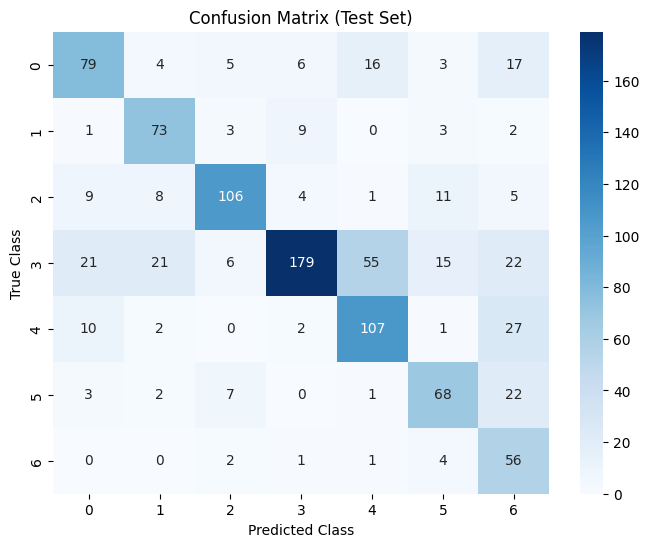

In [397]:
cm = confusion_matrix(
    data.y[data.test_mask].cpu(),
    pred_classes[data.test_mask].cpu()
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [398]:
test_mask = data.test_mask
y_true = data.y[test_mask].cpu()
y_pred = pred_classes[test_mask].cpu()

In [399]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, 
                          target_names=[f'Class {i}' for i in range(7)]))

              precision    recall  f1-score   support

     Class 0       0.64      0.61      0.62       130
     Class 1       0.66      0.80      0.73        91
     Class 2       0.82      0.74      0.78       144
     Class 3       0.89      0.56      0.69       319
     Class 4       0.59      0.72      0.65       149
     Class 5       0.65      0.66      0.65       103
     Class 6       0.37      0.88      0.52        64

    accuracy                           0.67      1000
   macro avg       0.66      0.71      0.66      1000
weighted avg       0.72      0.67      0.68      1000



In [400]:
test_indices = torch.where(data.test_mask)[0][:10]

In [401]:
for i, idx in enumerate(test_indices):
    true_class = data.y[idx].item()
    pred_class = pred_classes[idx].item()
    confidence = pred_probs[idx].max().item()
    
    print(f"Node {idx:4d}: True={true_class}, Pred={pred_class}, "
          f"Conf={confidence:.3f} {'correct' if true_class == pred_class else 'incorrect'}")
    
    # Show top 3 probabilities for first 3 examples
    if i < 3:
        probs = pred_probs[idx].cpu().numpy()
        top3_idx = np.argsort(probs)[-3:][::-1]
        for j, class_idx in enumerate(top3_idx):
            print(f"    Top-{j+1}: Class {class_idx} = {probs[class_idx]:.3f}")

Node 1708: True=3, Pred=2, Conf=0.969 incorrect
    Top-1: Class 2 = 0.969
    Top-2: Class 1 = 0.031
    Top-3: Class 5 = 0.000
Node 1709: True=2, Pred=2, Conf=0.996 correct
    Top-1: Class 2 = 0.996
    Top-2: Class 1 = 0.004
    Top-3: Class 0 = 0.000
Node 1710: True=2, Pred=2, Conf=0.988 correct
    Top-1: Class 2 = 0.988
    Top-2: Class 1 = 0.012
    Top-3: Class 0 = 0.000
Node 1711: True=2, Pred=2, Conf=1.000 correct
Node 1712: True=2, Pred=2, Conf=1.000 correct
Node 1713: True=0, Pred=2, Conf=0.999 incorrect
Node 1714: True=2, Pred=2, Conf=0.998 correct
Node 1715: True=2, Pred=2, Conf=1.000 correct
Node 1716: True=2, Pred=2, Conf=0.996 correct
Node 1717: True=2, Pred=2, Conf=0.999 correct


In [402]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()

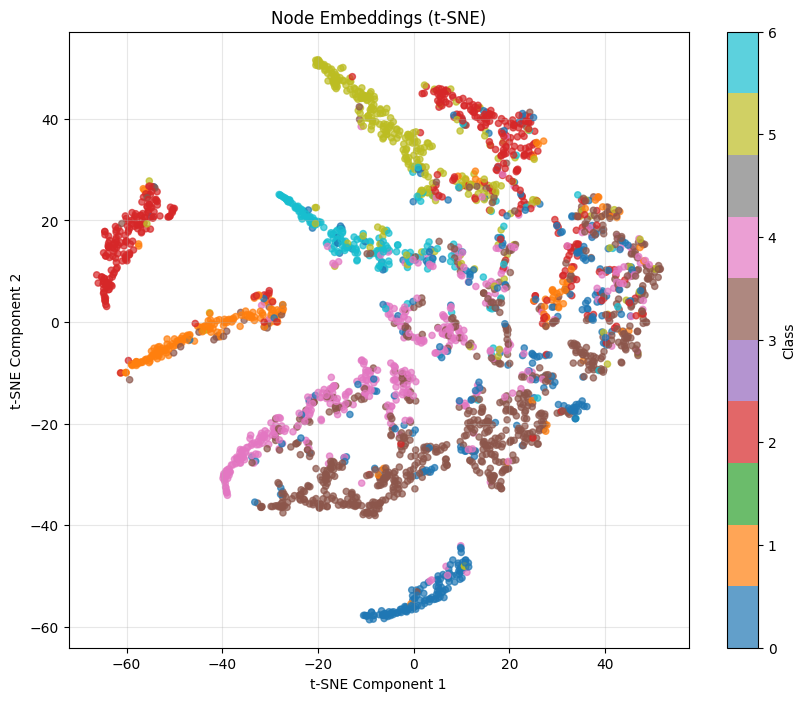

In [403]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=data.y.cpu().numpy(), cmap='tab10', 
                     alpha=0.7, s=20)
plt.colorbar(scatter, label='Class')
plt.title('Node Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)
plt.show()

In [404]:
# Pick some training nodes
train_nodes = torch.where(data.train_mask)[0][:5].cpu()
print(f"Selected nodes of interest: {train_nodes.tolist()}")

# Create 2-hop subgraph
subset, edge_index, _, _ = k_hop_subgraph(
    node_idx=train_nodes,
    num_hops=2,
    edge_index=data.edge_index.cpu(),
    relabel_nodes=True
)

print(f"Subgraph size: {len(subset)} nodes (original: {len(train_nodes)})")
print(f"Subgraph edges: {edge_index.shape[1]}")
print(f"Original indices of sampled nodes: {subset[:10].tolist()}...")

Selected nodes of interest: [0, 1, 2, 3, 4]
Subgraph size: 105 nodes (original: 5)
Subgraph edges: 312
Original indices of sampled nodes: [0, 1, 2, 3, 4, 45, 48, 49, 68, 71]...


In [405]:
final_val_acc = evaluate(model, data, data.val_mask)
final_test_acc = evaluate(model, data, data.test_mask)

print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Test Accuracy: {final_test_acc:.4f}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Validation Accuracy: 0.6720
Test Accuracy: 0.6680
Number of parameters: 966,291


# Pure PyTorch GCN Implementation (Alternative)

In [406]:
import os, sys, pickle
import scipy.sparse as sp
import networkx as nx
from time import time

base = 'data/Cora/Cora/raw'
def parse_index_file(filename):
    idx = []
    with open(filename) as f:
        for line in f: idx.append(int(line.strip()))
    return idx

def load_cora(path=base):
    import pickle, sys, os, numpy as np, scipy.sparse as sp, networkx as nx, torch
    names = ['x','tx','allx','y','ty','ally','graph']
    objects = {}
    for name in names:
        fn = os.path.join(path, f'ind.cora.{name}')
        with open(fn,'rb') as f:
            objects[name] = pickle.load(f, encoding='latin1')
    test_idx = parse_index_file(os.path.join(path,'ind.cora.test.index'))
    test_idx_range = np.sort(test_idx)
    x, tx, allx = objects['x'], objects['tx'], objects['allx']
    y, ty, ally = objects['y'], objects['ty'], objects['ally']
    features = sp.vstack((allx, tx)).tolil()
    features[test_idx, :] = features[test_idx_range, :]
    labels = np.vstack((ally, ty))
    labels[test_idx, :] = labels[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(objects['graph']))
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels.argmax(axis=1))
    n = labels.shape[0]
    train_mask = torch.zeros(n, dtype=torch.bool)
    val_mask = torch.zeros(n, dtype=torch.bool)
    test_mask = torch.zeros(n, dtype=torch.bool)
    train_mask[list(range(140))] = True
    val_mask[list(range(200,500))] = True
    test_mask[test_idx_range.tolist()] = True
    return features, adj, labels, train_mask, val_mask, test_mask

features, adj, labels, train_mask, val_mask, test_mask = load_cora()

def normalize_adj(adj):
    adj = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj).dot(D_inv_sqrt).tocoo()

adj_norm = normalize_adj(adj)
indices = torch.LongTensor([adj_norm.row, adj_norm.col])
values = torch.FloatTensor(adj_norm.data)
adj_torch = torch.sparse_coo_tensor(indices, values, torch.Size(adj_norm.shape)).coalesce()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features = features.to(device)
labels = labels.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)
adj_torch = adj_torch.to(device)

class GCNLayer(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.w = nn.Parameter(torch.randn(in_f, out_f) * 0.01)
        self.b = nn.Parameter(torch.zeros(out_f))
    
    def forward(self, x, adj):
        x = x.matmul(self.w)
        x = torch.sparse.mm(adj, x)
        return x + self.b

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout=0.5):
        super().__init__()
        self.gc1 = GCNLayer(nfeat, nhid)
        self.gc2 = GCNLayer(nhid, nclass)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

model_gcn = GCN(features.shape[1], 16, int(labels.max().item() + 1), dropout=0.5).to(device)
opt = optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)
best_val = 0
best_test = 0
patience = 100
pc = 0

for epoch in range(1000):
    model_gcn.train()
    opt.zero_grad()
    out = model_gcn(features, adj_torch)
    loss = F.nll_loss(out[train_mask], labels[train_mask])
    loss.backward()
    opt.step()
    
    model_gcn.eval()
    with torch.no_grad():
        preds = model_gcn(features, adj_torch).argmax(dim=1)
        train_acc = (preds[train_mask] == labels[train_mask]).float().mean().item()
        val_acc = (preds[val_mask] == labels[val_mask]).float().mean().item()
        test_acc = (preds[test_mask] == labels[test_mask]).float().mean().item()
    
    if val_acc > best_val:
        best_val = val_acc
        best_test = test_acc
        torch.save(model_gcn.state_dict(), 'best_model_pt.pth')
        pc = 0
    else:
        pc += 1
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch} loss={loss.item():.4f} train={train_acc:.4f} val={val_acc:.4f} test={test_acc:.4f}')
    
    if pc >= patience:
        print(f'Early stopping at {epoch}')
        break

print(f'Best val {best_val:.4f}, test {best_test:.4f}')
model_gcn.load_state_dict(torch.load('best_model_pt.pth', map_location=device))
with torch.no_grad():
    preds = model_gcn(features, adj_torch).argmax(dim=1)
    final_val = (preds[val_mask] == labels[val_mask]).float().mean().item()
    final_test = (preds[test_mask] == labels[test_mask]).float().mean().item()
    print(f'Final val {final_val:.4f}, Final test {final_test:.4f}')

Epoch 0 loss=1.9459 train=0.1000 val=0.0933 test=0.1130
Epoch 20 loss=0.6986 train=0.9786 val=0.7700 test=0.7850
Epoch 40 loss=0.0772 train=1.0000 val=0.7600 test=0.7980
Epoch 60 loss=0.0824 train=1.0000 val=0.7733 test=0.8070
Epoch 80 loss=0.0568 train=1.0000 val=0.7800 test=0.8090
Epoch 100 loss=0.0515 train=1.0000 val=0.7700 test=0.8080
Epoch 120 loss=0.0411 train=1.0000 val=0.7700 test=0.8070
Epoch 140 loss=0.0464 train=1.0000 val=0.7833 test=0.8120
Epoch 160 loss=0.0467 train=1.0000 val=0.7933 test=0.8100
Epoch 180 loss=0.0356 train=1.0000 val=0.7767 test=0.8110
Epoch 200 loss=0.0421 train=1.0000 val=0.7633 test=0.8080
Epoch 220 loss=0.0323 train=1.0000 val=0.7800 test=0.8070
Epoch 240 loss=0.0253 train=1.0000 val=0.7867 test=0.8070
Epoch 260 loss=0.0203 train=1.0000 val=0.7733 test=0.8090
Early stopping at 260
Best val 0.7933, test 0.8100
Final val 0.7933, Final test 0.8100


In [425]:
## Re-train GCN and collect training history for visualization
import copy

# Reset model and optimizer
model_gcn = GCN(features.shape[1], 16, int(labels.max().item() + 1), dropout=0.5).to(device)
optimizer_gcn = optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)

# Lists to store history
gcn_train_losses = []
gcn_train_accs = []
gcn_val_accs = []
gcn_test_accs = []

best_val_acc_gcn = 0
best_test_acc_gcn = 0
patience_gcn = 100
patience_counter_gcn = 0

for epoch in range(1000):
    model_gcn.train()
    optimizer_gcn.zero_grad()
    out = model_gcn(features, adj_torch)
    loss = F.nll_loss(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer_gcn.step()
    
    model_gcn.eval()
    with torch.no_grad():
        preds = model_gcn(features, adj_torch).argmax(dim=1)
        train_acc = (preds[train_mask] == labels[train_mask]).float().mean().item()
        val_acc = (preds[val_mask] == labels[val_mask]).float().mean().item()
        test_acc = (preds[test_mask] == labels[test_mask]).float().mean().item()
    
    # Store history
    gcn_train_losses.append(loss.item())
    gcn_train_accs.append(train_acc)
    gcn_val_accs.append(val_acc)
    gcn_test_accs.append(test_acc)
    
    if val_acc > best_val_acc_gcn:
        best_val_acc_gcn = val_acc
        best_test_acc_gcn = test_acc
        torch.save(model_gcn.state_dict(), 'best_model_pt.pth')
        patience_counter_gcn = 0
    else:
        patience_counter_gcn += 1
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch:3d} | Loss: {loss.item():.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}')
    
    if patience_counter_gcn >= patience_gcn:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'\nBest validation accuracy: {best_val_acc_gcn:.4f}')
print(f'Best test accuracy: {best_test_acc_gcn:.4f}')

# Load best model
model_gcn.load_state_dict(torch.load('best_model_pt.pth', map_location=device))
gcn_test_acc = best_test_acc_gcn
gcn_val_acc = best_val_acc_gcn
print(f'Final GCN Test Accuracy: {gcn_test_acc:.4f}')
print(f'Final GCN Val Accuracy: {gcn_val_acc:.4f}')

Epoch   0 | Loss: 1.9459 | Train: 0.3000 | Val: 0.3667 | Test: 0.3830
Epoch  50 | Loss: 0.0875 | Train: 1.0000 | Val: 0.7800 | Test: 0.7970
Epoch 100 | Loss: 0.0415 | Train: 1.0000 | Val: 0.7633 | Test: 0.7990
Epoch 150 | Loss: 0.0492 | Train: 1.0000 | Val: 0.7867 | Test: 0.8020
Epoch 200 | Loss: 0.0335 | Train: 1.0000 | Val: 0.7833 | Test: 0.7990
Epoch 250 | Loss: 0.0328 | Train: 1.0000 | Val: 0.7833 | Test: 0.8040
Early stopping at epoch 288

Best validation accuracy: 0.8100
Best test accuracy: 0.8200
Final GCN Test Accuracy: 0.8200
Final GCN Val Accuracy: 0.8100


### GCN Training Loss

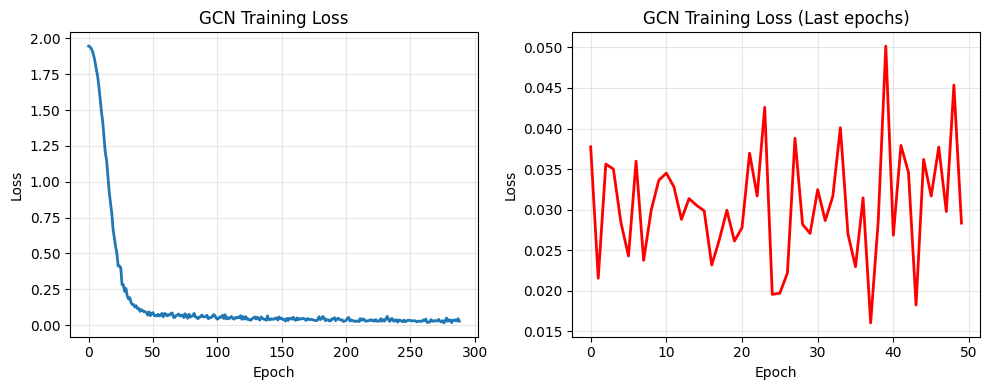

In [426]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(gcn_train_losses, linewidth=2)
plt.title('GCN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Plot last 50 losses to see detail
if len(gcn_train_losses) > 50:
    plt.plot(gcn_train_losses[-50:], linewidth=2, color='red')
else:
    plt.plot(gcn_train_losses, linewidth=2, color='red')
plt.title('GCN Training Loss (Last epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### GCN Accuracies

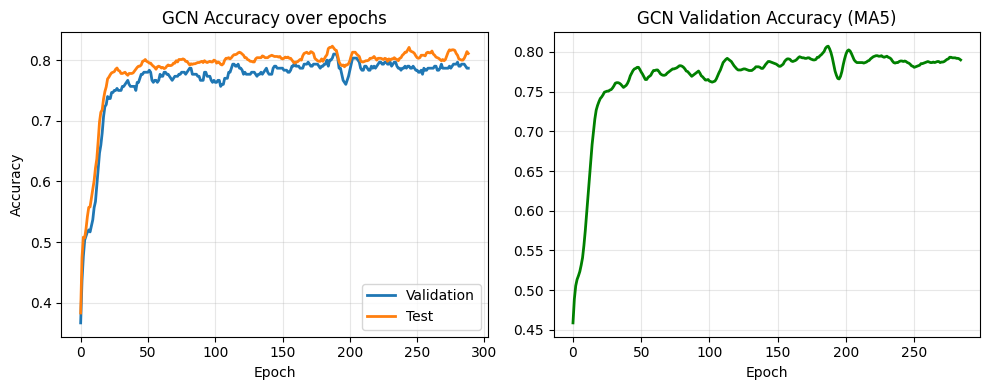

In [427]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(gcn_val_accs, label='Validation', linewidth=2)
plt.plot(gcn_test_accs, label='Test', linewidth=2)
plt.title('GCN Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Moving average
window = 5
if len(gcn_val_accs) > window:
    val_ma_gcn = np.convolve(gcn_val_accs, np.ones(window)/window, mode='valid')
    plt.plot(val_ma_gcn, linewidth=2, color='green')
else:
    plt.plot(gcn_val_accs, linewidth=2, color='green')
plt.title(f'GCN Validation Accuracy (MA{window})')
plt.xlabel('Epoch')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

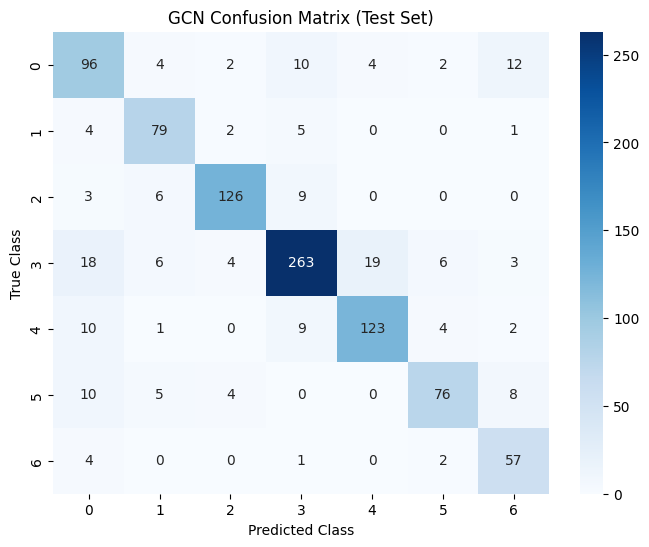

In [428]:
model_gcn.eval()
with torch.no_grad():
    preds_gcn = model_gcn(features, adj_torch).argmax(dim=1)
    
cm_gcn = confusion_matrix(
    labels[test_mask].cpu(),
    preds_gcn[test_mask].cpu()
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gcn, annot=True, fmt='d', cmap='Blues')
plt.title('GCN Confusion Matrix (Test Set)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [429]:
y_true_gcn = labels[test_mask].cpu()
y_pred_gcn = preds_gcn[test_mask].cpu()

print(classification_report(y_true_gcn, y_pred_gcn, 
                          target_names=[f'Class {i}' for i in range(7)]))

              precision    recall  f1-score   support

     Class 0       0.66      0.74      0.70       130
     Class 1       0.78      0.87      0.82        91
     Class 2       0.91      0.88      0.89       144
     Class 3       0.89      0.82      0.85       319
     Class 4       0.84      0.83      0.83       149
     Class 5       0.84      0.74      0.79       103
     Class 6       0.69      0.89      0.78        64

    accuracy                           0.82      1000
   macro avg       0.80      0.82      0.81      1000
weighted avg       0.83      0.82      0.82      1000



In [430]:
test_indices_gcn = torch.where(test_mask)[0][:10]

model_gcn.eval()
with torch.no_grad():
    logits_gcn = model_gcn(features, adj_torch)
    probs_gcn = torch.exp(logits_gcn)
    preds_gcn_all = logits_gcn.argmax(dim=1)

print("GCN Example Predictions (First 10 test nodes):\n")
for i, idx in enumerate(test_indices_gcn):
    true_class = labels[idx].item()
    pred_class = preds_gcn_all[idx].item()
    confidence = probs_gcn[idx].max().item()
    
    print(f"Node {idx:4d}: True={true_class}, Pred={pred_class}, "
          f"Conf={confidence:.3f} {'✓' if true_class == pred_class else '✗'}")
    
    # Show top 3 probabilities for first 3 examples
    if i < 3:
        probs = probs_gcn[idx].cpu().numpy()
        top3_idx = np.argsort(probs)[-3:][::-1]
        for j, class_idx in enumerate(top3_idx):
            print(f"    Top-{j+1}: Class {class_idx} = {probs[class_idx]:.3f}")

GCN Example Predictions (First 10 test nodes):

Node 1708: True=3, Pred=1, Conf=0.859 ✗
    Top-1: Class 1 = 0.859
    Top-2: Class 3 = 0.044
    Top-3: Class 2 = 0.042
Node 1709: True=2, Pred=2, Conf=0.988 ✓
    Top-1: Class 2 = 0.988
    Top-2: Class 3 = 0.005
    Top-3: Class 1 = 0.004
Node 1710: True=2, Pred=2, Conf=0.699 ✓
    Top-1: Class 2 = 0.699
    Top-2: Class 1 = 0.154
    Top-3: Class 3 = 0.097
Node 1711: True=2, Pred=2, Conf=0.998 ✓
Node 1712: True=2, Pred=2, Conf=0.970 ✓
Node 1713: True=0, Pred=0, Conf=0.525 ✓
Node 1714: True=2, Pred=2, Conf=0.992 ✓
Node 1715: True=2, Pred=2, Conf=0.995 ✓
Node 1716: True=2, Pred=2, Conf=0.978 ✓
Node 1717: True=2, Pred=2, Conf=0.995 ✓


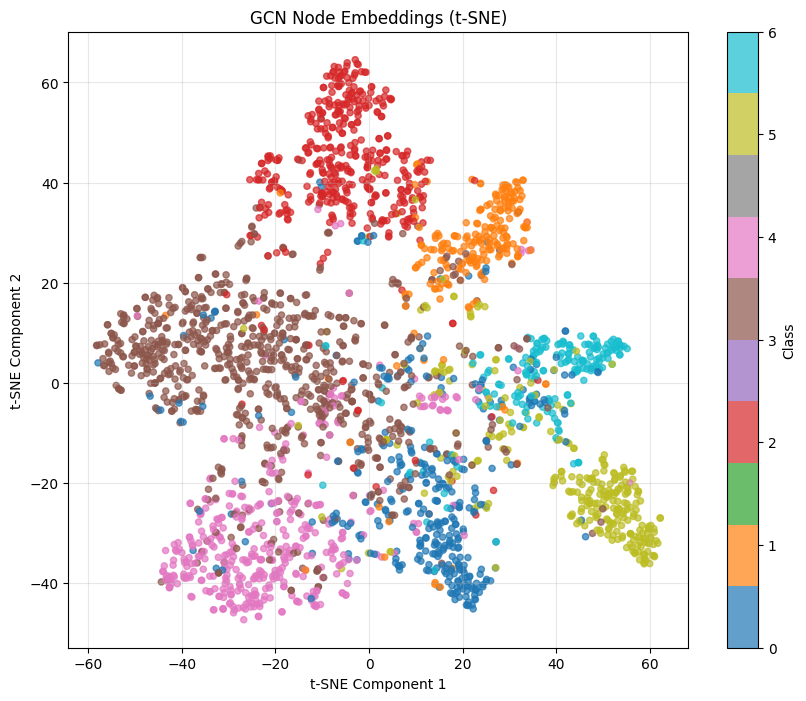

In [431]:
model_gcn.eval()
with torch.no_grad():
    # Get embeddings from first GCN layer (hidden layer)
    x_hidden = features.matmul(model_gcn.gc1.w)
    x_hidden = torch.sparse.mm(adj_torch, x_hidden)
    embeddings_gcn = x_hidden.cpu().numpy()

tsne_gcn = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_gcn_2d = tsne_gcn.fit_transform(embeddings_gcn)

plt.figure(figsize=(10, 8))
scatter_gcn = plt.scatter(embeddings_gcn_2d[:, 0], embeddings_gcn_2d[:, 1], 
                         c=labels.cpu().numpy(), cmap='tab10', 
                         alpha=0.7, s=20)
plt.colorbar(scatter_gcn, label='Class')
plt.title('GCN Node Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)
plt.show()

In [432]:
print("="*60)
print("GCN MODEL SUMMARY")
print("="*60)
print(f"\nModel Parameters: {sum(p.numel() for p in model_gcn.parameters()):,}")
print(f"\nFinal Accuracies:")
print(f"  Validation: {gcn_val_acc:.4f}")
print(f"  Test:       {gcn_test_acc:.4f}")
print(f"\nTraining Statistics:")
print(f"  Total epochs trained: {len(gcn_train_losses)}")
print(f"  Final loss: {gcn_train_losses[-1]:.6f}")
print(f"  Best validation accuracy: {max(gcn_val_accs):.4f}")
print(f"  Best test accuracy: {max(gcn_test_accs):.4f}")
print("="*60)

GCN MODEL SUMMARY

Model Parameters: 23,063

Final Accuracies:
  Validation: 0.8100
  Test:       0.8200

Training Statistics:
  Total epochs trained: 289
  Final loss: 0.028345
  Best validation accuracy: 0.8100
  Best test accuracy: 0.8230
